In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [45]:
url_train = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/train.csv'
train_df = pd.read_csv(url_train, index_col=0)
train_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.760019,0.0,0.758755,0.146447,0.146447
0.738174,0.0,0.560765,0.066987,0.250000
0.698884,0.0,0.463513,0.017037,0.370590
0.668238,0.0,0.370029,0.000000,0.500000
0.643093,0.0,0.325101,0.017037,0.629410


In [46]:
url_val = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/val.csv'
val_df = pd.read_csv(url_val, index_col=0)
val_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.457646,0.01,0.700153,0.370590,0.017037
0.460946,0.20,0.769918,0.250000,0.066987
0.459375,0.05,0.872750,0.146447,0.146447
0.456388,0.20,0.776894,0.066987,0.250000
0.440830,0.05,0.664574,0.017037,0.370590


In [47]:
url_test = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/test.csv'
test_df = pd.read_csv(url_test, index_col=0)
test_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.767405,0.9,0.401563,0.000000,0.500000
0.756876,0.9,0.348821,0.017037,0.629410
0.754833,0.9,0.302637,0.066987,0.750000
0.754833,0.9,0.187108,0.146447,0.853553
0.756247,0.9,0.080926,0.250000,0.933013


In [48]:
train_df = train_df.reset_index()
val_df   = val_df.reset_index()
test_df  = test_df.reset_index()

## Implementing the DataWindow class

In [49]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df, val_df, test_df,
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result
    

class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]
    

class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            # If no target is specified, return the last known value of all columns over the next 24 timesteps
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        
        # Return the last known value of the target column over the next 24 timesteps.
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

## Single-step baseline model

We’ll first implement a single-step model as a baseline. In a single-step model, the input is one timestep and the output is the prediction of the next timestep. 

The first step is to generate a window of data. Since we are defining a single-step model, the input width is 1, the label width is 1, and the shift is also 1, since the model predicts the next timestep. Our target variable is the volume of traffic.

In [50]:
single_step_window = DataWindow(input_width=1, 
                                label_width=1, 
                                shift=1, 
                                label_columns=['traffic_volume'], 
                                train_df=train_df, val_df=val_df, test_df=test_df)

For plotting purposes, we'll also define a wider window so we can visualize many predictions of our model.

In [51]:
wide_window = DataWindow(input_width=24, 
                         label_width=24, 
                         shift=1,
                         label_columns=['traffic_volume'],
                         train_df=train_df, val_df=val_df, test_df=test_df)

TensorFlow requires us to provide a loss function and a metric of evaluation. In this case, and throughout the deep learning chapters, we'll use the mean squared error (MSE) as a loss function—it penalizes large errors, and it generally yields well-fitted models.

In [52]:
# Generate a dictionary with the name and index of each column in the training set
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Pass the index of the target column in the Baseline class.
baseline_last = Baseline(label_index=column_indices['traffic_volume'])

In [53]:
# Compile the model to generate the predictions.
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

Models built with TensorFlow conveniently come with the evaluate method, which allows us to compare the predictions to the actual values and calculate the error metric.

In [54]:

val_performance = {} # Create a dictionary to hold the MAE of a model on the validation set.
performance = {} # Create a dictionary to hold the MAE of a model on the test set.

# Store the MAE of the baseline model on the validation set.
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)

# Store the MAE of the baseline model on the test set.
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - mean_absolute_error: 0.0856


Great, we have successfully built a baseline that predicts the last known value and evaluated it. We can visualize the predictions using the plot method of the DataWindow class. Remember to use the wide_window to see more than just two data points.

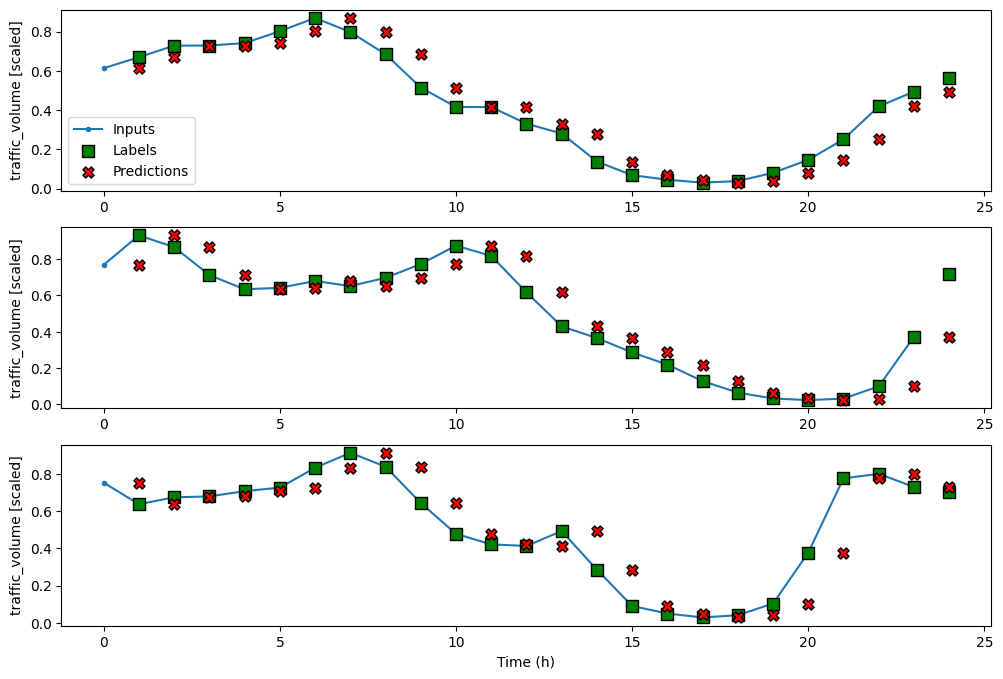

In [55]:
wide_window.plot(baseline_last)

Predictions of our baseline single-step model on three sequences from the sample batch. The prediction at each timestep is the last known value, meaning that our baseline works as expected.

We can optionally print the MAE of our baseline on the test set.

In [56]:
print(performance['Baseline - Last'][1])

0.08128398656845093


This returns an MAE of 0.081. More complex models should perform better than the baseline, resulting in a smaller 

## Multi-step baseline models

For multi-step models, we'll predict more than one timestep into the future. In this case, we'll forecast the traffic volume for the next 24 hours of data given an input of 24 hours.

Again, the first step is to generate the appropriate window of data. Because we wish to predict 24 timesteps into the future with an input of 24 hours, the input width is 24, the label width is 24, and the shift is also 24.

In [57]:
multi_window = DataWindow(input_width=24, 
                          label_width=24, 
                          shift=24, 
                          label_columns=['traffic_volume'],
                          train_df=train_df, val_df=val_df, test_df=test_df)

* Predict the last known value for the next 24 timesteps.
* Predict the last 24 timesteps for the next 24 timesteps.

In [58]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

### Predictin the last know value

To predict the last known value, we'll define a MultiStepLastBaseline class that simply takes in the input and repeats the last value of the input sequence over 24 timesteps.

In [59]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            # If no target is specified, return the last known value of all columns over the next 24 timesteps
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        
        # Return the last known value of the target column over the next 24 timesteps.
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

Next we'll initialize the class and specify the target column.

In [60]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)

ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1871 - mean_absolute_error: 0.3518


We can now visualize the predictions using the plot method of DataWindow.

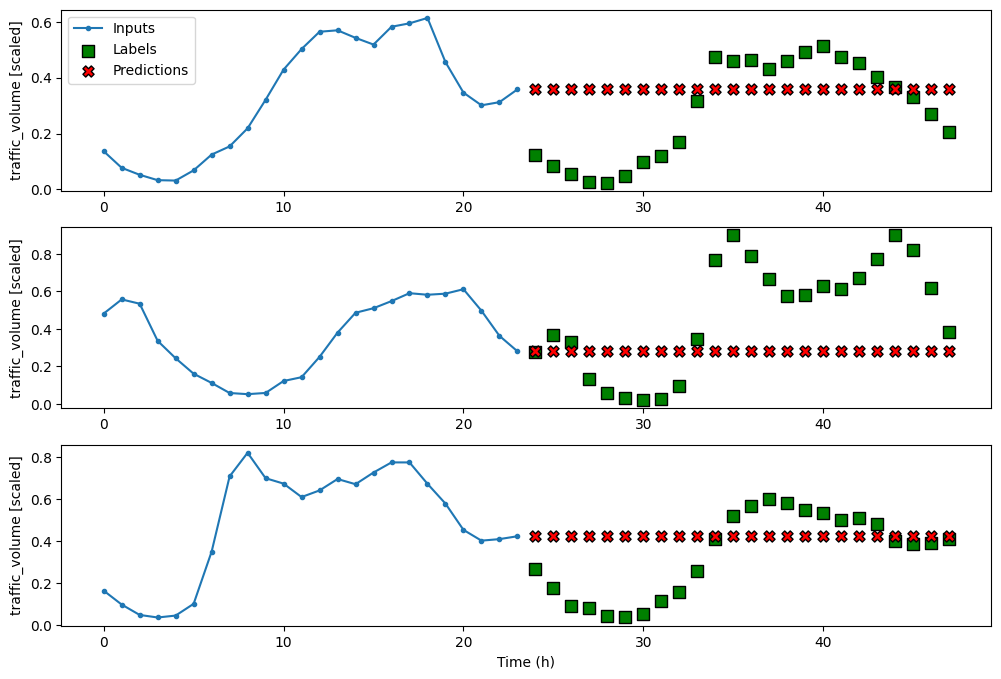

In [61]:
multi_window.plot(ms_baseline_last)

Predicting the last known value for the next 24 timesteps. We can see that the predictions, shown as crosses, correspond to the last value of the input sequence, so our baseline behaves as expected.

Again, we can optionally print the baseline’s MAE. We can expect it to be fairly high, since there is a large discrepancy between the labels and the predictions.

In [62]:
print(ms_performance['Baseline - Last'][1])

0.34697425365448


This gives an MAE of 0.347. Now let’s see if we can build a better baseline by simply repeating the input sequence.

### Repeating the input sequence

Let’s implement a second baseline for multi-step models, which simply returns the input sequence. This means that the prediction for the next 24 hours will simply be the last known 24 hours of data. This is implemented through the RepeatBaseline class.

In [63]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        # Return the input sequence for the given target column.
        return inputs[:, :, self.label_index:]

Now we can initialize the baseline model and generate predictions. Note that the loss function and evaluation metric remain the same.

In [64]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)

ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1895 - mean_absolute_error: 0.3272


Next we can visualize the predictions.

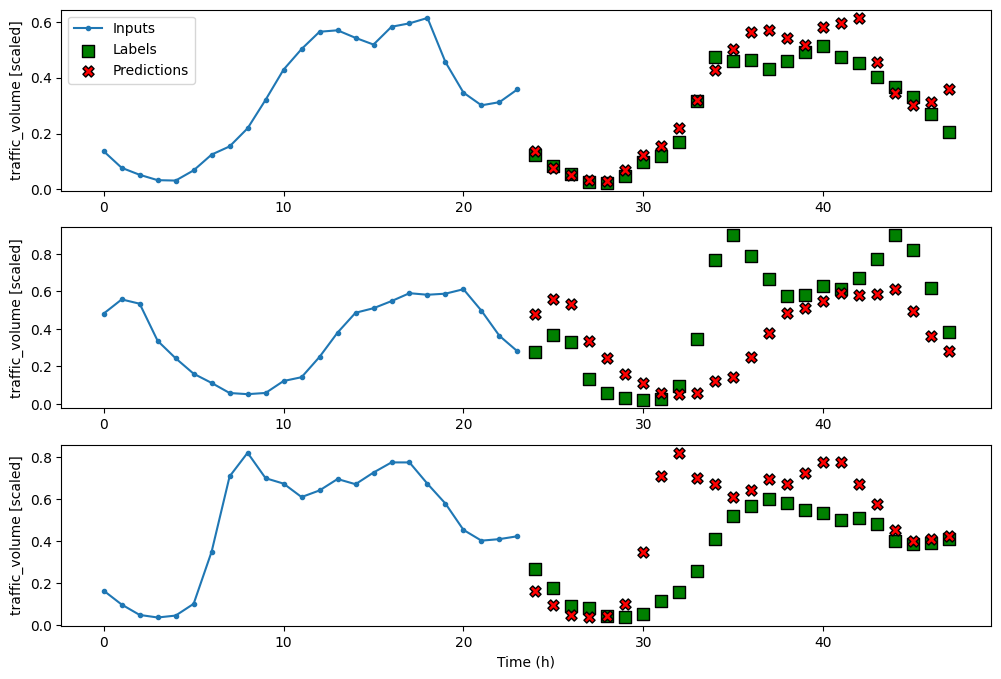

In [65]:
multi_window.plot(ms_baseline_repeat)

Repeating the input sequence as the predictions. You’ll see that the predictions (represented as crosses) match exactly the input sequence. You’ll also notice that many predictions overlap the labels, which indicates that this baseline performs quite well.

Again, we can print the MAE on the test set to verify that we indeed have a better baseline than simply predicting the last known value.

In [66]:
print(ms_performance['Baseline - Repeat'][1])

0.3153636157512665


This gives an MAE of 0.315, which is lower than the MAE obtained by predicting the last known value. We have therefore successfully built a better baseline.

## Multi-output baseline model

In this situation, we wish to predict the traffic volume and the temperature for the next timestep using a single input data point. Essentially, we’re applying the single-step model on both the traffic volume and temperature, making it a multi-output model.

Again, we’ll start off by defining the window of data, but here we’ll define two windows: one for training and the other for visualization. Since the model takes in one data point and outputs one prediction, we want to initialize a wide window of data to visualize many predictions over many timesteps.


In [67]:
mo_single_step_window = DataWindow(input_width=1, 
                                   label_width=1, 
                                   shift=1,
                                   label_columns=['temp','traffic_volume'],
                                   train_df=train_df, val_df=val_df, test_df=test_df
                                )


mo_wide_window = DataWindow(input_width=24, 
                            label_width=24, 
                            shift=1,
                            label_columns=['temp','traffic_volume'],
                            train_df=train_df, val_df=val_df, test_df=test_df
                            )


Then we’ll use the Baseline class that we defined for the single-step model. Recall that this class can output the last known value for a list of targets.

In [68]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        # If no target is specified, we return all columns. This is useful 
        # for multi-output models where all columns are to be predicted.
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
                
        # Return the input for a given target variable.
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In the case of the multi-output model, we must simply pass the indexes of the temp and traffic_volume columns to output the last known value for the respective variables as a prediction.

In [69]:
# Prints out 2
print(column_indices['traffic_volume'])
# Prints out 0
print(column_indices['temp'])

mo_baseline_last = Baseline(label_index=[0, 2])

2
0


With the baseline initialized with our two target variables, we can now compile the model and evaluate it.

In [73]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [74]:
mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068 - mean_absolute_error: 0.0480


Finally, we can visualize the predictions against the actual values.

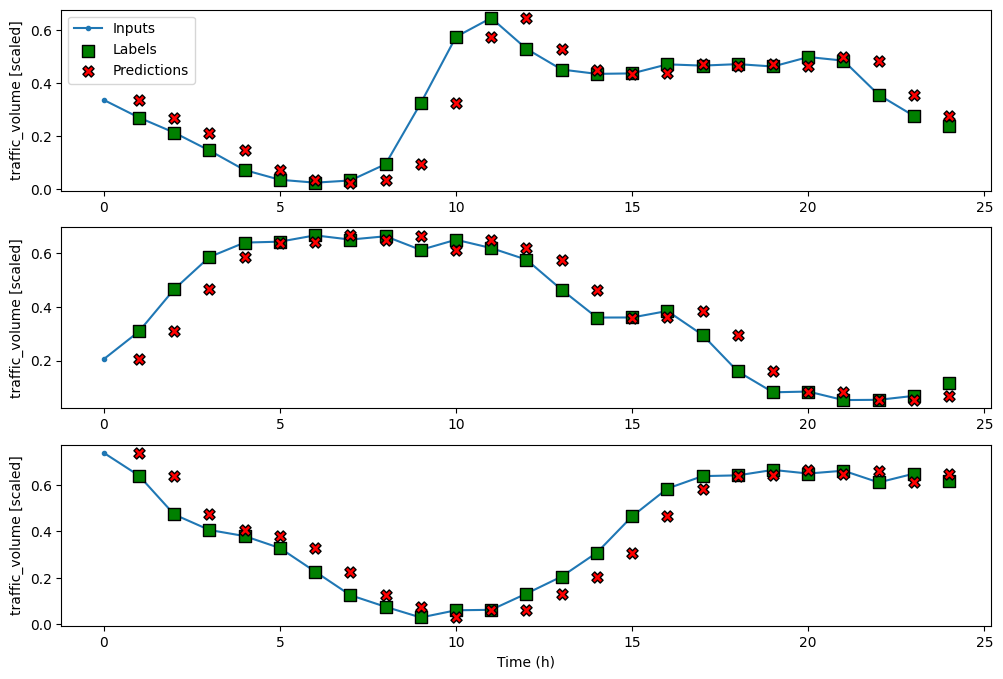

In [75]:
mo_wide_window.plot(mo_baseline_last)

Figure does not show anything surprising, as we already saw these results when we built a single-step baseline model. The particularity of the multi-output model is that we also have predictions for the temperature. Of course, we can also visualize the predictions for the temperature by specifying the target in the plot method.

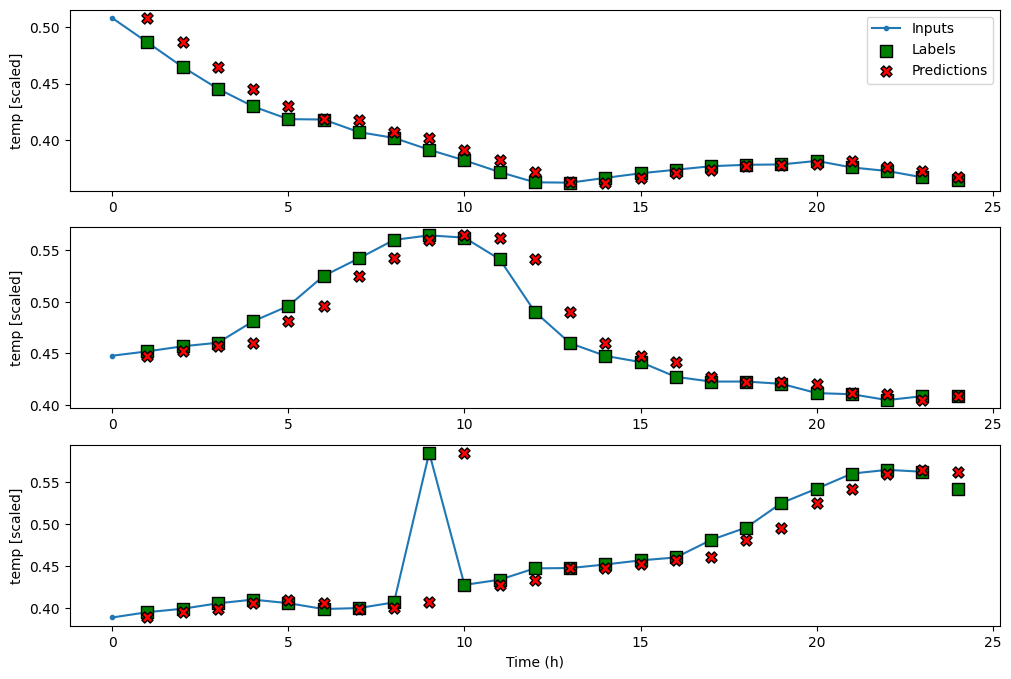

In [76]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

The predictions (crosses) are equal to the previous data point, so our baseline model behaves as expected.

Again, we can print the MAE of our baseline model.

In [77]:
print(mo_performance['Baseline - Last'])

[0.00643845833837986, 0.04710666462779045]


We obtain an MAE of 0.047 on the test set. In the next chapter, we’ll start building more complex models, and they should result in a lower MAE, as they will be trained to fit the data.